# HSCT survival: Kullback-Leibler divergence

## Notebook set-up

In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

import configuration as config

notebook_num='02.3'
gpu=0

# Data files
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
kld_features_file=f'{config.PROCESSED_DATA}/{notebook_num}-kld_survival.pkl'

## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets['Continuous target encoded'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>


## 2. Data preparation

In [3]:
input_features=['CoxPH survival','CoxPH partial hazard','WeibullAFT survival','WeibullAFT expectation']

training_df=data_dict['Training labels']
training_df['CoxPH survival']=coxph_features['Training survival']
training_df['CoxPH partial hazard']=np.log(coxph_features['Training partial hazard'])
training_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_df['WeibullAFT expectation']=np.log(weibullaft_features['Training expectation'])

testing_df=data_dict['Testing labels']
testing_df['CoxPH survival']=coxph_features['Testing survival']
testing_df['CoxPH partial hazard']=np.log(coxph_features['Testing partial hazard'])
testing_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_df['WeibullAFT expectation']=np.log(weibullaft_features['Testing expectation'])

scaler=StandardScaler()
scaler.fit(training_df[input_features])
training_df[input_features]=scaler.transform(training_df[input_features])
testing_df[input_features]=scaler.transform(testing_df[input_features])

efs_one=training_df[training_df['efs'] == 0]
efs_zero=training_df[training_df['efs'] == 1]

training_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
efs,20160.0,5.390873e-01,0.498482,0.000000,0.000000,1.000000,1.000000,1.000000
efs_time,20160.0,2.329701e+01,24.924465,0.333000,5.625500,9.826000,35.183500,156.819000
CoxPH survival,20160.0,1.064404e-16,1.000025,-2.389052,-0.706981,-0.106571,0.573035,2.525002
CoxPH partial hazard,20160.0,1.665335e-17,1.000025,-3.677598,-0.424942,0.164732,0.655778,2.972068
WeibullAFT survival,20160.0,3.965082e-17,1.000025,-0.890911,-0.693222,-0.392147,0.259939,3.733253
WeibullAFT expectation,20160.0,4.236470e-16,1.000025,-2.913624,-0.662215,-0.181390,0.450361,3.714172


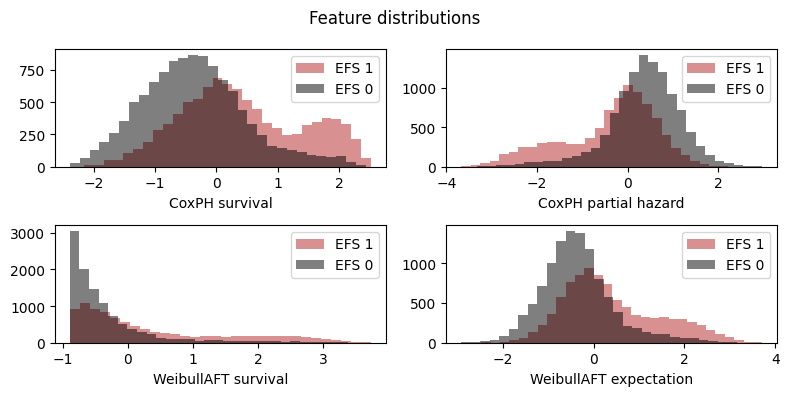

In [4]:
fig, axs=plt.subplots(2,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(input_features):
    axs[i].hist(efs_one[feature], bins=30, color='firebrick', alpha=0.5, label='EFS 1')
    axs[i].hist(efs_zero[feature], bins=30, color='black', alpha=0.5, label='EFS 0')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()

## 3. Kernel density estimation

In [5]:
kdes={}

for feature in input_features:

    feature_min=min(training_df[feature])
    feature_max=max(training_df[feature])
    feature_range=feature_max-feature_min
    padding=feature_range*0.05
    x=np.linspace(feature_min-padding, feature_max+padding)

    efs_zero_kde=gaussian_kde(
        efs_zero[feature].values, 
        bw_method='silverman'
    )

    efs_one_kde=gaussian_kde(
        efs_one[feature].values, 
        bw_method='silverman'
    )

    kdes[feature]={
        'x': x,
        'EFS one': efs_one_kde(x),
        'EFS zero': efs_zero_kde(x)
    }


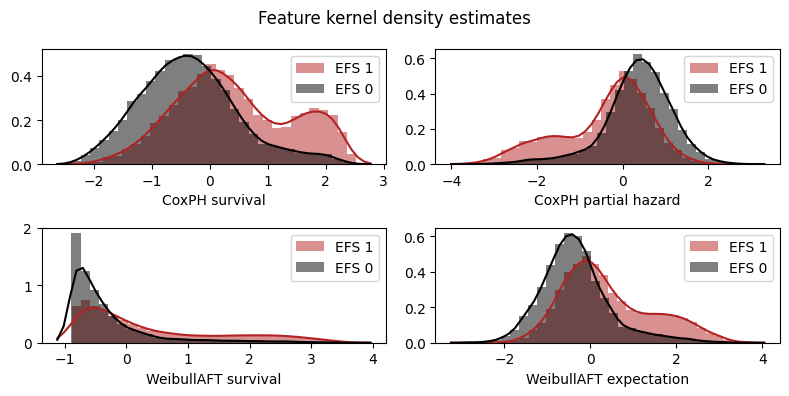

In [6]:
fig, axs=plt.subplots(2,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Feature kernel density estimates')

for i, feature in enumerate(input_features):
    axs[i].hist(efs_one[feature], bins=30, density=True, color='firebrick', alpha=0.5, label='EFS 1')
    axs[i].hist(efs_zero[feature], bins=30, density=True, color='black', alpha=0.5, label='EFS 0')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS one'], color='firebrick')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS zero'], color='black')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()

## 4. Kullback-Leibler divergence

In [7]:
for feature in input_features:

    # Convert inputs to numpy
    p=np.asarray(kdes[feature]['EFS one'])
    q=np.asarray(kdes[feature]['EFS zero'])

    # Set handling for overflows/underflows - just ignore. We will handle infinite
    # or nan values later by just filtering them out.
    with np.errstate(over='ignore', under='ignore', divide='ignore', invalid='ignore'):
        kld_values=p * np.log2(p/q)

    kdes[feature]['KLD']=kld_values

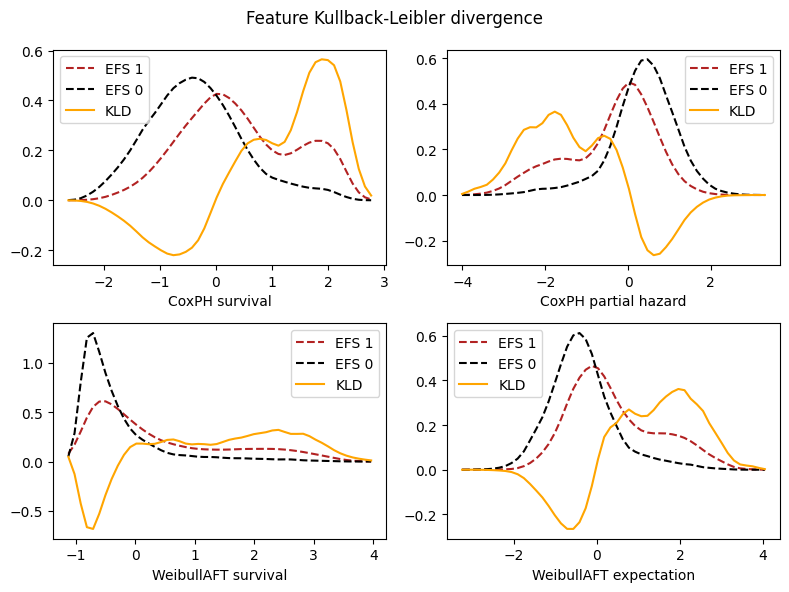

In [8]:
fig, axs=plt.subplots(2,2, figsize=(8,6))
axs=axs.flatten()

fig.suptitle('Feature Kullback-Leibler divergence')

for i, feature in enumerate(input_features):
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS one'], linestyle='dashed', color='firebrick', label='EFS 1')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS zero'], linestyle='dashed', color='black', label='EFS 0')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['KLD'], color='orange', label='KLD')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()

## 5. KLD kernel density estimate

In [9]:
for feature in input_features:

    # Construct new padded x range
    x_min=min(kdes[feature]['x'])
    x_max=max(kdes[feature]['x'])
    x_range=x_max-x_min
    padding=x_range*0.05
    x=np.linspace(x_min-padding, x_max+padding)

    # Shift the kld values so that they are non-negative
    kld_abs=abs(min(kdes[feature]['KLD']))
    kld=kdes[feature]['KLD'] + kld_abs

    # Scale the values so when we convert to integer we get good
    # resolution, e.g. we don't want to collapse 2.1, 2.2, 2.3 etc.,
    # to 2. Instead, 2100.0, 2200.0, 2300.0 become 2100, 2200, 2300 etc.
    kld=kld * 100000

    # Convert to integer
    kld_counts=kld.astype(int)

    # Now, construct a list where each value of x appears a number of times
    # equal to it's KLD 'count'
    kld_scores=[]

    for i, _ in enumerate(kld_counts):
        kld_scores.extend([x[i]] * kld_counts[i])

    kld_kde=gaussian_kde(
        kld_scores, 
        bw_method='silverman'
    )

    # Clip x back to the original range of the data
    feature_min=min(training_df[feature])
    feature_max=max(training_df[feature])
    feature_range=feature_max-feature_min
    padding=feature_range*0.05
    x=np.linspace(feature_min-padding, feature_max+padding)

    kdes[feature]['x']=x
    kdes[feature]['KLD KDE values']=kld_kde(x)
    kdes[feature]['KLD KDE']=kld_kde

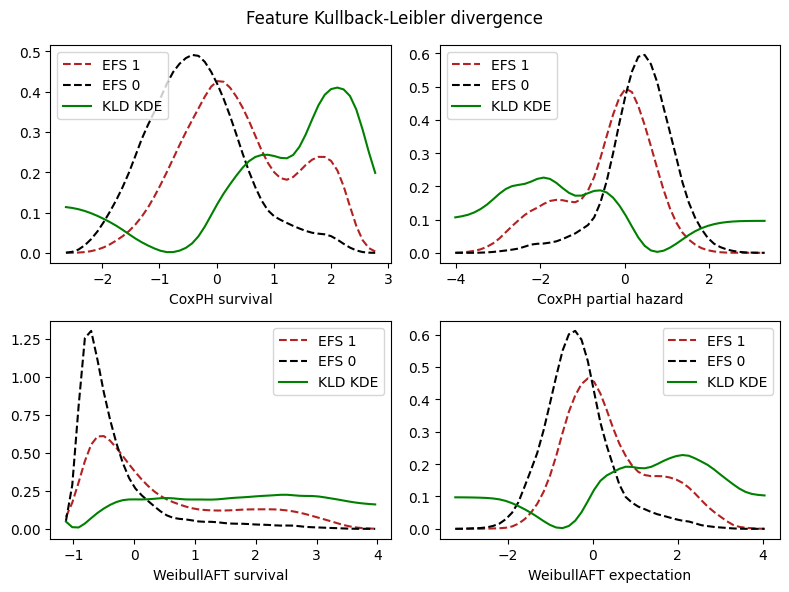

In [10]:
fig, axs=plt.subplots(2,2, figsize=(8,6))
axs=axs.flatten()

fig.suptitle('Feature Kullback-Leibler divergence')

for i, feature in enumerate(input_features):
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS one'], linestyle='dashed', color='firebrick', label='EFS 1')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['EFS zero'], linestyle='dashed', color='black', label='EFS 0')
    axs[i].plot(kdes[feature]['x'],kdes[feature]['KLD KDE values'], color='Green', label='KLD KDE')
    axs[i].set_xlabel(feature)
    axs[i].legend(loc='best')

fig.tight_layout()
fig.show()

## 6. Score training and testing data

In [11]:
for feature in input_features:
    kld_scores=kdes[feature]['KLD KDE'](training_df[feature])
    training_df[f'{feature}_KLD']=kld_scores

    kld_scores=kdes[feature]['KLD KDE'](testing_df[feature])
    testing_df[f'{feature}_KLD']=kld_scores

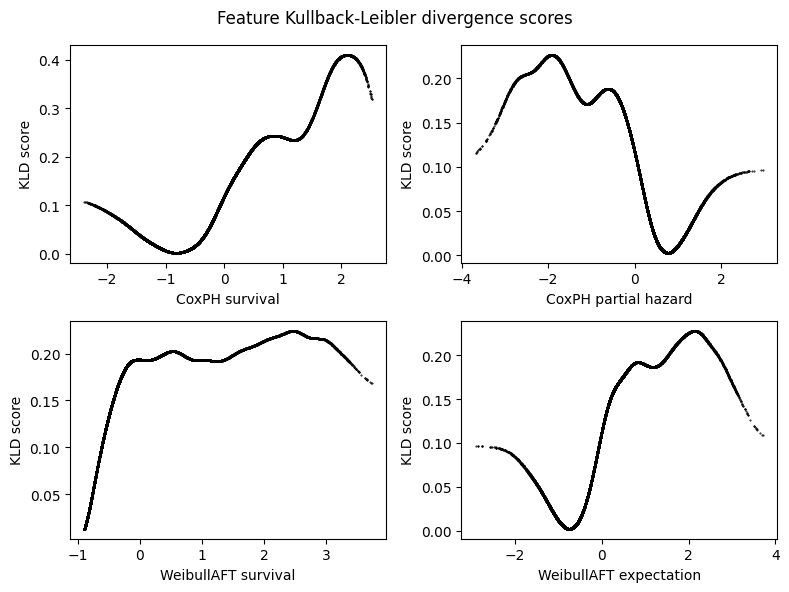

In [16]:
fig, axs=plt.subplots(2,2, figsize=(8,6))
axs=axs.flatten()

fig.suptitle('Feature Kullback-Leibler divergence scores')

for i, feature in enumerate(input_features):
    axs[i].scatter(training_df[feature], training_df[f'{feature}_KLD'], s=0.2, color='black')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('KLD score')

fig.tight_layout()
fig.show()

## 7. Save KLD features

In [18]:
training_df.head(len(training_df)).transpose()

,0,1,2,3,4,5,6,7,8,9,...,20150,20151,20152,20153,20154,20155,20156,20157,20158,20159
efs,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
efs_time,2.142000,105.944000,34.787000,6.964000,5.541000,61.895000,5.823000,4.447000,23.760000,7.019000,...,71.698000,33.973000,29.300000,11.556000,5.981000,4.597000,6.343000,4.322000,8.839000,6.875000
CoxPH survival,-1.130176,-0.487891,0.330596,-1.392048,-0.356860,-1.061736,1.795555,-1.310648,0.248514,-0.265842,...,2.010277,0.301668,2.105570,-0.243633,0.548184,0.918275,-0.174147,-0.094757,0.379437,-0.469968
CoxPH partial hazard,1.011662,0.476844,-0.206633,1.247938,0.370090,0.952496,-1.862834,1.172482,-0.135076,0.295736,...,-2.242465,-0.181295,-2.437379,0.277549,-0.402017,-0.760055,0.220492,0.154952,-0.249725,0.462248
WeibullAFT survival,-0.540704,-0.345462,0.578549,-0.815323,-0.088218,-0.487573,2.114362,-0.616864,-0.423564,-0.716850,...,2.250977,0.380354,2.495805,-0.038005,-0.184489,0.895423,-0.112106,-0.535598,0.368258,-0.437159
WeibullAFT expectation,-0.384046,-0.125364,0.701136,-1.036516,0.144507,-0.306406,1.855810,-0.509820,-0.220832,-0.717584,...,1.968965,0.547378,2.182208,0.191771,0.049688,0.937576,0.121528,-0.376276,0.537774,-0.238385
CoxPH survival_KLD,0.013521,0.016887,0.189198,0.033098,0.034206,0.009318,0.370951,0.026356,0.173329,0.051782,...,0.407199,0.183673,0.410172,0.056721,0.225488,0.243030,0.073457,0.093983,0.198323,0.018745
CoxPH partial hazard_KLD,0.011728,0.020090,0.155592,0.030034,0.036422,0.008223,0.225828,0.023652,0.143484,0.050829,...,0.212908,0.151479,0.205738,0.054653,0.179588,0.185044,0.067188,0.082180,0.162108,0.021991
WeibullAFT survival_KLD,0.122338,0.167594,0.202286,0.033208,0.193294,0.136455,0.216690,0.100038,0.151563,0.066914,...,0.219713,0.199384,0.224263,0.193784,0.188713,0.193022,0.192772,0.123733,0.198979,0.148531
WeibullAFT expectation_KLD,0.030119,0.084123,0.189473,0.013795,0.143451,0.043747,0.220257,0.013871,0.061645,0.002239,...,0.224844,0.180249,0.227697,0.150619,0.125404,0.190869,0.139510,0.031361,0.179594,0.057760


In [22]:
kld_features={
    'Training CoxPH survival KLD':training_df['CoxPH survival_KLD'].values,
    'Training CoxPH partial hazard KLD':training_df['CoxPH partial hazard_KLD'].values,
    'Training WeibullAFT survival KLD':training_df['WeibullAFT survival_KLD'].values,
    'Training WeibullAFT expectation KLD':training_df['WeibullAFT expectation_KLD'].values,
    'Testing CoxPH survival KLD':testing_df['CoxPH survival_KLD'].values,
    'Testing CoxPH partial hazard KLD':testing_df['CoxPH partial hazard_KLD'].values,
    'Testing WeibullAFT survival KLD':testing_df['WeibullAFT survival_KLD'].values,
    'Testing WeibullAFT expectation KLD':testing_df['WeibullAFT expectation_KLD'].values
}

with open(kld_features_file, 'wb') as output_file:
    pickle.dump(kld_features, output_file)